In [127]:
# imports

import mrcnn
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
import cv2
import os
from skimage.io import imread
from tensorflow import keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
from os import listdir
from os.path import isdir
from glob import glob
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [193]:
os.getcwd()

'/home/msds2021/qmendez/ThirdTerm/ML2/ML_Project/maskrcnn'

In [48]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Trash Classification using CNN

## Mask RCNN

### Set up the Mask RCNN to Tensorflow 2.0

In [4]:
class_list = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 
               'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 
               'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 
               'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 
               'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
               'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 
               'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 
               'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 
               'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 
               'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
               'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 
               'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 
               'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 
               'scissors', 'teddy bear', 'Biodegradable', 'Non-biodegarable']

In [5]:
# load the class label names from disk, one label per line
# CLASS_NAMES = open("coco_labels.txt").read().strip().split("\n")

CLASS_NAMES = class_list.copy()

class SimpleConfig(mrcnn.config.Config):
    # Give the configuration a recognizable name
    NAME = "coco_inference"
    
    # set the number of GPUs to use along with the number of images per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

	# Number of classes = number of classes + 1 (+1 for the background). The background class is named BG
    NUM_CLASSES = len(CLASS_NAMES)

# Initialize the Mask R-CNN model for inference and then load the weights.
# This step builds the Keras model architecture.
model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

# # Load the weights into the model.

model.load_weights(filepath="mask_rcnn_coco.h5", 
                   by_name=True)

Instructions for updating:
Use fn_output_signature instead


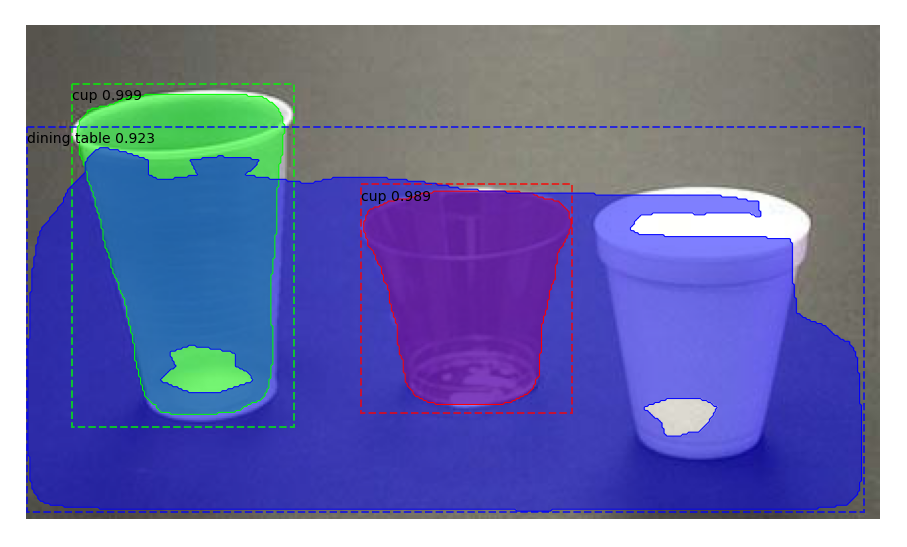

In [7]:
image = imread("images/image053.jpg")
# Run detection
results = model.detect([image], verbose=0)

# Visualize results
r = results[0]
mrcnn.visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            CLASS_NAMES, r['scores'])

### Segment each image in dataset using Mask RCNN

In [ ]:
# Set trash image size to be 160x160 pixels
required_size = (160, 160)

def create_dataset_dir(folder_dir, required_size = (160, 160)):
    X = []
    Y = []
    
    # Iterate over the directory that contains the dataset
    for subdir in list(glob(folder_dir)):
        
        # Get the name of the type of trash in the dataset
        type_trash = subdir.split('/')[-1]
        
        print("Processing ... {}".format(type_trash))
        
        # Define path to a particular subdirectory
        dir_path = subdir +'/*'
        
        # Find all trash in all images in the subdirectory
        trash_list = []
        
        # Start the image file name with (type of trash)_(file_num)
        file_num = 0

        # Iterate over all images in subdirectory
        for img_path in tqdm(list(glob(dir_path))):
          # Read the image  
          image = skimage.io.imread(img_path)

          # Run detection
          results = model.detect([image], verbose=0)
            
            if len(results[0]['scores']) != 0:
                idx = results[0]['scores'].argmax()
                res = results[0]['rois'][idx]

            else:
                continue # In case the results[0]['scores'] is empty

          # Bounding box
          y1, x1, y2, x2 = res

          # Get trash
          trash = image[y1:y2, x1:x2]

          # Resize trash image
          trash = Image.fromarray(trash)
        trash = trash.resize(required_size)
    
          # Convert image to numpy array
          trash = np.asarray(trash)

          # Store to list
          trash_list.append(trash)
      
          # Make directory for the rescaled images
          try:
            os.mkdir('/content/gdrive/My Drive/ml_project/set_up_maskrcnn/images/'
              'segmented_data/{}'.format(type_trash))
        
        except FileExistsError:
            pass

      # Saving the trash images
      plt.imsave('/content/gdrive/My Drive/ml_project/set_up_maskrcnn/images/'
              'segmented_data/{}/{}_{}.jpg'.format(type_trash, type_trash,file_num), trash)
      
      # Iterating the file numbers per trash type
      file_num += 1

    # Create labels Y
    labels = [subdir for _ in range(len(trash_list))]

    # Store in list
    X.extend(trash_list)
    Y.extend(labels)

    print("Done processing ... {}\n\n\n".format(type_trash))

  # Convert to numpy array and return          
  return np.asarray(X), np.asarray(Y)

In [ ]:
dir_path = '/content/gdrive/MyDrive/ml_project/set_up_maskrcnn/images/kaggle_trash_data/*'
array1, array2 = create_dataset_dir(dir_path)

## Training the CNN Model

In [22]:
# Imports

import os, shutil
import re
import random
import pandas as pd
from PIL import Image
import PIL.ImageOps
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

from keras import layers
from keras import models
from keras.preprocessing import image

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
import keras.optimizers as opt
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers.core import Dropout, Flatten, Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras.metrics import categorical_accuracy
from keras.layers import Input, AveragePooling2D
from tensorflow.keras import regularizers

np.random.seed(42)
%matplotlib inline

### Dataset Preparation (Train, Test and Valid)

In [35]:
original_dir = '/home/msds2021/qmendez/ThirdTerm/ML2/ML_Project/maskrcnn/data'
base_dir = 'results'

# Create base directory
os.makedirs(base_dir, exist_ok=True)

# Create training, test, and val directory

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

shutil.rmtree(train_dir, ignore_errors=True)
shutil.rmtree(val_dir, ignore_errors=True)
shutil.rmtree(test_dir, ignore_errors=True)

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [36]:
trashes = ['bio', 'non-bio']


# Create directories train, val, and test set per trash
for trash in trashes:
    train_trash_dir = os.path.join(train_dir, trash)
    val_trash_dir = os.path.join(val_dir, trash)
    test_trash_dir = os.path.join(test_dir, trash)
    os.makedirs(train_trash_dir, exist_ok=True)
    os.makedirs(val_trash_dir, exist_ok=True)
    os.makedirs(test_trash_dir, exist_ok=True)

    trash_paths = list(filter(lambda x: x.split('_')[0] == trash,
                               os.listdir(original_dir)))
    
    random.Random(1).shuffle(trash_paths)
    
    # 60% training
    start_idx, end_idx = 0, int(len(trash_paths) * 0.80)
    train_trashes = trash_paths[start_idx:end_idx]

    # 25% validation
    start_idx = end_idx
    end_idx += int(len(trash_paths) * 0.10)
    val_trashes = trash_paths[start_idx:end_idx]

    # 15% test
    start_idx = end_idx
    end_idx += int(len(trash_paths) * 0.10)
    test_trashes = trash_paths[start_idx:end_idx]

    # Copy train trashes to training dataset
    for x in train_trashes:
        src = os.path.join(original_dir, x)
        dst = os.path.join(train_trash_dir, x)
        shutil.copyfile(src, dst)
        
    print('{} train images: {}'.format(trash, len(train_trashes)))
    
    if trash == trash[0]:
        train_bio_count = len(train_trashes)
    else:
        train_non_bio_count = len(train_trashes)
    
    # Copy val trashes to val dataset
    for x in val_trashes:
        src = os.path.join(original_dir, x)
        dst = os.path.join(val_trash_dir, x)
        shutil.copyfile(src, dst)
        
    print('{} validation images: {}'.format(trash, len(val_trashes)))

    # Copy test trashes to test dataset
    for x in test_trashes:
        src = os.path.join(original_dir, x)
        dst = os.path.join(test_trash_dir, x)
        shutil.copyfile(src, dst)
        
    print('{} test images: {}'.format(trash, len(test_trashes)))

bio train images: 566
bio validation images: 70
bio test images: 70
non-bio train images: 853
non-bio validation images: 106
non-bio test images: 106


### Get Class Weights

In [37]:
train_bio_count = 566
train_non_bio_count = 853

In [38]:
train_dist_sim = []
for i in range(train_bio_count):
    train_dist_sim.append(0)

for i in range(train_non_bio_count):
    train_dist_sim.append(1)

In [39]:
from collections import Counter
Counter(train_dist_sim)

Counter({0: 566, 1: 853})

In [40]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_integers = train_dist_sim
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
dict_class_weights = dict(enumerate(class_weights))
dict_class_weights

{0: 1.2535335689045937, 1: 0.8317702227432591}

### Data Generator

In [123]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(160, 160),
                                                    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(160, 160),
                                                class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                target_size=(160, 160),
                                                class_mode='categorical')

Found 1419 images belonging to 2 classes.
Found 176 images belonging to 2 classes.
Found 176 images belonging to 2 classes.


In [124]:
# Add callbacks

checkpointer = ModelCheckpoint(filepath="/home/msds2021/qmendez/ThirdTerm/ML2/ML_Project/maskrcnn/model/best.hdf5",
                               monitor='val_accuracy',
                               verbose=1,
                               save_best_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_accuracy',
                                   factor=0.7,
                                   patience=3,
                                   verbose=1,
                                   cooldown=2,
                                   min_lr=0.0001)

early = EarlyStopping(monitor="val_accuracy",
                      mode="min",
                      patience=10)

### Xception

#### Without freezing any layers

In [125]:
from keras.applications import Xception

def Xception_baseline_model():
    conv_base = Xception(weights='imagenet',
                    include_top=False,
                    input_shape=(160, 160, 3))
    model=Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [135]:
Xception_baseline = Xception_baseline_model()

Xception_results = Xception_baseline.fit_generator(train_generator,
                              epochs=50,
                              validation_data=val_generator,
                              callbacks=checkpointer,
                              verbose=1)

Epoch 1/50
45/45 [==============================] - 17s 254ms/step - loss: 1.2976 - accuracy: 0.5640 - val_loss: 0.6911 - val_accuracy: 0.6023

Epoch 00001: val_accuracy did not improve from 0.88636
Epoch 2/50
45/45 [==============================] - 10s 227ms/step - loss: 0.6908 - accuracy: 0.5837 - val_loss: 0.6877 - val_accuracy: 0.6023

Epoch 00002: val_accuracy did not improve from 0.88636
Epoch 3/50
45/45 [==============================] - 10s 215ms/step - loss: 0.6861 - accuracy: 0.6135 - val_loss: 0.6840 - val_accuracy: 0.6023

Epoch 00003: val_accuracy did not improve from 0.88636
Epoch 4/50
45/45 [==============================] - 10s 220ms/step - loss: 0.6848 - accuracy: 0.5959 - val_loss: 0.6812 - val_accuracy: 0.6023

Epoch 00004: val_accuracy did not improve from 0.88636
Epoch 5/50
45/45 [==============================] - 10s 222ms/step - loss: 0.6820 - accuracy: 0.5926 - val_loss: 0.6786 - val_accuracy: 0.6023

Epoch 00005: val_accuracy did not improve from 0.88636
Epoch

In [136]:
max(Xception_results.history['val_accuracy'])

0.8977272510528564

In [53]:
Xception_baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dropout (Dropout)            (None, 51200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 33,969,450
Trainable params: 33,914,922
Non-trainable params: 54,528
_________________________________________________________________


#### Freeze the layers

In [58]:
Xception_freeze = Xception_baseline_model(freeze_layer = False)

Xception_results = Xception_freeze.fit_generator(train_generator,
                              epochs=300,
                              validation_data=val_generator,
                              callbacks=[checkpointer, reduceLROnPlat, early],
                              verbose=1)

Epoch 1/300
29/29 [==============================] - 12s 342ms/step - loss: 3.0714 - accuracy: 0.7218 - val_loss: 0.5607 - val_accuracy: 0.8636

Epoch 00001: val_accuracy improved from 0.60227 to 0.86364, saving model to /home/msds2021/qmendez/ThirdTerm/ML2/ML_Project/maskrcnn/model/best.hdf5
Epoch 2/300
29/29 [==============================] - 9s 302ms/step - loss: 0.4511 - accuracy: 0.8655 - val_loss: 0.4499 - val_accuracy: 0.8466

Epoch 00002: val_accuracy did not improve from 0.86364
Epoch 3/300
29/29 [==============================] - 9s 303ms/step - loss: 0.3430 - accuracy: 0.8812 - val_loss: 0.3472 - val_accuracy: 0.8636

Epoch 00003: val_accuracy did not improve from 0.86364
Epoch 4/300
29/29 [==============================] - 9s 296ms/step - loss: 0.2305 - accuracy: 0.9084 - val_loss: 0.4019 - val_accuracy: 0.8693

Epoch 00004: val_accuracy improved from 0.86364 to 0.86932, saving model to /home/msds2021/qmendez/ThirdTerm/ML2/ML_Project/maskrcnn/model/best.hdf5
Epoch 5/300
29/

#### Freeze some layers

In [80]:
def Xception_freeze_layers(layer_num):
    conv_base = Xception(weights='imagenet',
                    include_top=False,
                    input_shape=(160, 160, 3))
    model=Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    
    conv_base.trainable = True
    
    for layer in conv_base.layers[:layer_num]:
        layer.trainable = False
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [79]:
# Freeze until last 6 layers
Xception_freeze_V1 = Xception_freeze_layers()

Xception_freeze_results = Xception_freeze_V1.fit_generator(train_generator,
                              epochs=300,
                              validation_data=val_generator,
                              callbacks=[checkpointer, reduceLROnPlat, early],
                              verbose=1)

Epoch 1/300
29/29 [==============================] - 18s 532ms/step - loss: 2.0783 - accuracy: 0.6889 - val_loss: 0.2757 - val_accuracy: 0.8523

Epoch 00001: val_accuracy did not improve from 0.89773
Epoch 2/300
29/29 [==============================] - 9s 308ms/step - loss: 0.3083 - accuracy: 0.8351 - val_loss: 0.9297 - val_accuracy: 0.8466

Epoch 00002: val_accuracy did not improve from 0.89773
Epoch 3/300
29/29 [==============================] - 9s 298ms/step - loss: 0.2089 - accuracy: 0.9098 - val_loss: 0.3943 - val_accuracy: 0.8750

Epoch 00003: val_accuracy did not improve from 0.89773
Epoch 4/300
29/29 [==============================] - 9s 307ms/step - loss: 0.1732 - accuracy: 0.9302 - val_loss: 0.5499 - val_accuracy: 0.8693

Epoch 00004: val_accuracy did not improve from 0.89773
Epoch 5/300
29/29 [==============================] - 9s 298ms/step - loss: 0.1383 - accuracy: 0.9477 - val_loss: 0.6856 - val_accuracy: 0.8807

Epoch 00005: val_accuracy did not improve from 0.89773
Epoc

In [82]:
# Freeze layer until last 10 layers
Xception_freeze_V2 = Xception_freeze_layers(layer_num=-10)

Xception_freeze2_results = Xception_freeze_V2.fit_generator(train_generator,
                              epochs=300,
                              validation_data=val_generator,
                              callbacks=[checkpointer, reduceLROnPlat, early],
                              verbose=1)

Epoch 1/300
29/29 [==============================] - 14s 416ms/step - loss: 1.4586 - accuracy: 0.6821 - val_loss: 6.1714 - val_accuracy: 0.6648

Epoch 00001: val_accuracy did not improve from 0.90909
Epoch 2/300
29/29 [==============================] - 9s 305ms/step - loss: 0.3015 - accuracy: 0.8777 - val_loss: 0.7013 - val_accuracy: 0.8295

Epoch 00002: val_accuracy did not improve from 0.90909
Epoch 3/300
29/29 [==============================] - 9s 303ms/step - loss: 0.2397 - accuracy: 0.8855 - val_loss: 0.5094 - val_accuracy: 0.8466

Epoch 00003: val_accuracy did not improve from 0.90909
Epoch 4/300
29/29 [==============================] - 9s 300ms/step - loss: 0.2338 - accuracy: 0.8955 - val_loss: 0.4892 - val_accuracy: 0.8693

Epoch 00004: val_accuracy did not improve from 0.90909
Epoch 5/300
29/29 [==============================] - 9s 300ms/step - loss: 0.1746 - accuracy: 0.9331 - val_loss: 0.3949 - val_accuracy: 0.8920

Epoch 00005: val_accuracy did not improve from 0.90909
Epoc

In [93]:
Xception_freeze_V2.save('xception.h5')

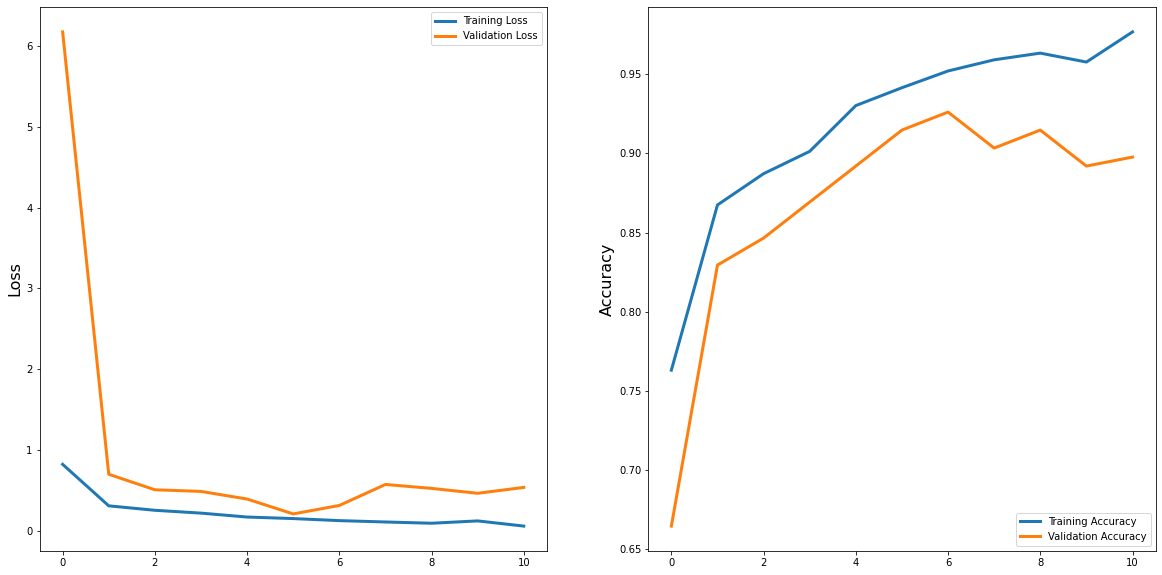

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.ylabel('Loss', fontsize=16)
plt.plot(Xception_freeze2_results.history['loss'], label='Training Loss', lw=3.0)
plt.plot(Xception_freeze2_results.history['val_loss'], label='Validation Loss', lw=3.0)
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(Xception_freeze2_results.history['accuracy'], label='Training Accuracy', lw=3.0)
plt.plot(Xception_freeze2_results.history['val_accuracy'], label='Validation Accuracy', lw=3.0)
plt.legend(loc='lower right')

plt.show()

In [158]:
Xception_freeze_V2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_8 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 51200)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 514       
Total params: 33,969,450
Trainable params: 18,604,290
Non-trainable params: 15,365,160
_________________________________________________________________


0.84375


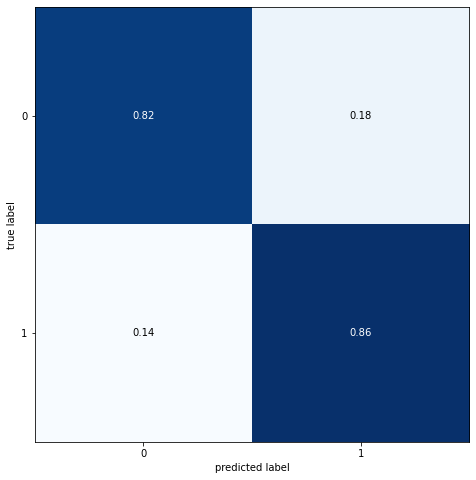

In [133]:
from skimage.io import imshow
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

x, y = next(val_generator)

y_pred = np.argmax(Xception_freeze_V2.predict(x), axis=1)
y_true = np.argmax(y, axis=1)
print(sum(y_pred ==y_true)/len(y_true))
conf_mat = confusion_matrix(y_true, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                figsize=(8, 8))

### Inception

In [90]:
from keras.applications import InceptionResNetV2

def inception_baseline_model(freeze_layer = True):
    conv_base = InceptionResNetV2(weights='imagenet',
                    include_top=False,
                    input_shape=(160, 160, 3))
    model=Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    
    conv_base.trainable = freeze_layer
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

#### Freeze Layers

In [92]:
inception_freeze = inception_baseline_model(freeze_layer = False)

inception_results = inception_freeze.fit_generator(train_generator,
                              epochs=300,
                              validation_data=val_generator,
                              callbacks=[checkpointer, reduceLROnPlat, early],
                              verbose=1)

219062272/219055592 [==============================] - 11s 0us/step
Epoch 1/300
29/29 [==============================] - 24s 497ms/step - loss: 6.1861 - accuracy: 0.6340 - val_loss: 0.4330 - val_accuracy: 0.8580

Epoch 00001: val_accuracy did not improve from 0.92614
Epoch 2/300
29/29 [==============================] - 9s 306ms/step - loss: 0.4125 - accuracy: 0.8422 - val_loss: 0.3934 - val_accuracy: 0.8466

Epoch 00002: val_accuracy did not improve from 0.92614
Epoch 3/300
29/29 [==============================] - 9s 300ms/step - loss: 0.3455 - accuracy: 0.8367 - val_loss: 0.2703 - val_accuracy: 0.8750

Epoch 00003: val_accuracy did not improve from 0.92614
Epoch 4/300
29/29 [==============================] - 9s 312ms/step - loss: 0.2610 - accuracy: 0.8916 - val_loss: 0.2677 - val_accuracy: 0.8750

Epoch 00004: val_accuracy did not improve from 0.92614
Epoch 5/300
29/29 [==============================] - 9s 314ms/step - loss: 0.2747 - accuracy: 0.8902 - val_loss: 0.3476 - val_accuracy:

#### Without freezing any layers

In [106]:
inception_notfreeze = inception_baseline_model(freeze_layer = True)

inception_results_v1 = inception_notfreeze.fit_generator(train_generator,
                              epochs=300,
                              validation_data=val_generator,
                              callbacks=[checkpointer, reduceLROnPlat, early],
                              verbose=1)

Epoch 1/300
29/29 [==============================] - 30s 455ms/step - loss: 1.2386 - accuracy: 0.6671 - val_loss: 2836489.7500 - val_accuracy: 0.6023

Epoch 00001: val_accuracy did not improve from 0.92614
Epoch 2/300
29/29 [==============================] - 10s 321ms/step - loss: 0.4419 - accuracy: 0.7984 - val_loss: 3670.5232 - val_accuracy: 0.6023

Epoch 00002: val_accuracy did not improve from 0.92614
Epoch 3/300
29/29 [==============================] - 10s 332ms/step - loss: 0.2839 - accuracy: 0.8846 - val_loss: 6829.6606 - val_accuracy: 0.6420

Epoch 00003: val_accuracy did not improve from 0.92614
Epoch 4/300
29/29 [==============================] - 10s 327ms/step - loss: 0.2381 - accuracy: 0.9043 - val_loss: 581.5709 - val_accuracy: 0.7216

Epoch 00004: val_accuracy did not improve from 0.92614
Epoch 5/300
29/29 [==============================] - 10s 330ms/step - loss: 0.2257 - accuracy: 0.9235 - val_loss: 30.8798 - val_accuracy: 0.7955

Epoch 00005: val_accuracy did not improv

### VGG19

In [107]:
from keras.applications import VGG19

def vgg19_baseline_model(freeze_layer = True):
    conv_base = VGG19(weights='imagenet',
                    include_top=False,
                    input_shape=(160, 160, 3))
    model=Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    
    conv_base.trainable = freeze_layer
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [108]:
vgg19_freeze = vgg19_baseline_model(freeze_layer = False)
vgg19_results = vgg19_freeze.fit_generator(train_generator,
                              epochs=300,
                              validation_data=val_generator,
                              callbacks=[checkpointer, reduceLROnPlat, early],
                              verbose=1)

Epoch 1/300
29/29 [==============================] - 16s 473ms/step - loss: 1.2875 - accuracy: 0.5641 - val_loss: 0.5153 - val_accuracy: 0.7045

Epoch 00001: val_accuracy did not improve from 0.92614
Epoch 2/300
29/29 [==============================] - 9s 311ms/step - loss: 0.4789 - accuracy: 0.7537 - val_loss: 0.4738 - val_accuracy: 0.7159

Epoch 00002: val_accuracy did not improve from 0.92614
Epoch 3/300
29/29 [==============================] - 9s 314ms/step - loss: 0.4407 - accuracy: 0.7871 - val_loss: 0.4564 - val_accuracy: 0.7841

Epoch 00003: val_accuracy did not improve from 0.92614
Epoch 4/300
29/29 [==============================] - 9s 315ms/step - loss: 0.4212 - accuracy: 0.7976 - val_loss: 0.4557 - val_accuracy: 0.7330

Epoch 00004: val_accuracy did not improve from 0.92614
Epoch 5/300
29/29 [==============================] - 9s 306ms/step - loss: 0.3871 - accuracy: 0.7928 - val_loss: 0.4054 - val_accuracy: 0.7784

Epoch 00005: val_accuracy did not improve from 0.92614
Epoc

In [109]:
vgg19_unfreeze = vgg19_baseline_model(freeze_layer = True)
vgg19_results1 = vgg19_freeze.fit_generator(train_generator,
                              epochs=300,
                              validation_data=val_generator,
                              callbacks=[checkpointer, reduceLROnPlat, early],
                              verbose=1)

Epoch 1/300
29/29 [==============================] - 11s 387ms/step - loss: 0.3013 - accuracy: 0.8619 - val_loss: 0.4172 - val_accuracy: 0.8011

Epoch 00001: val_accuracy did not improve from 0.92614
Epoch 2/300
29/29 [==============================] - 9s 309ms/step - loss: 0.2981 - accuracy: 0.8640 - val_loss: 0.4818 - val_accuracy: 0.7784

Epoch 00002: val_accuracy did not improve from 0.92614
Epoch 3/300
29/29 [==============================] - 9s 307ms/step - loss: 0.2803 - accuracy: 0.8753 - val_loss: 0.4147 - val_accuracy: 0.8125

Epoch 00003: val_accuracy did not improve from 0.92614
Epoch 4/300
29/29 [==============================] - 9s 299ms/step - loss: 0.2707 - accuracy: 0.8710 - val_loss: 0.4293 - val_accuracy: 0.8011

Epoch 00004: val_accuracy did not improve from 0.92614
Epoch 5/300
29/29 [==============================] - 9s 312ms/step - loss: 0.2682 - accuracy: 0.8851 - val_loss: 0.4077 - val_accuracy: 0.7955

Epoch 00005: val_accuracy did not improve from 0.92614
Epoc

## Overall Flow of the Method

### Load the Mask RCNN model

In [94]:
%cd /home/msds2021/qmendez/ThirdTerm/ML2/ML_Project/maskrcnn/

/home/msds2021/qmendez/ThirdTerm/ML2/ML_Project/maskrcnn


In [95]:
# Load the model of the pre-trained Xception model
cnn_model = keras.models.load_model('xception.h5')

In [10]:
# Read the image to run in the model
# Using Mask RCNN

image = imread("/home/msds2021/qmendez/ThirdTerm/ML2/ML_Project/maskrcnn/ml_project/bottle.jpg")

# Run detection using MaskRCNN
results = model.detect([image], verbose=0)

In [13]:
r = results[0]
trash_list = []
required_size = (160, 160)

for score in range(len(r['scores'])):
    res =r['rois'][score]
    
    #Bounding box
    
    y1, x1, y2, x2 = res
    
    # Get trash
    
    trash = image[y1:y2, x1:x2]
    
    # Resize trash image
    
    trash = Image.fromarray(trash)
    trash = trash.resize(required_size)
    
    # Convert image to numpy array
    trash = np.asarray(trash)
    
    # Store to list
    trash_list.append(trash)

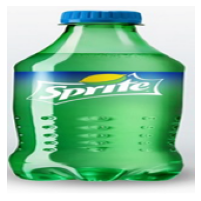

In [14]:
i = 1
plt.figure(figsize = (20,20))
for f in trash_list:
    plt.subplot(5, 5, i)
    plt.axis('off')
    plt.imshow(f)
    i += 1
    
plt.show()

In [15]:
pred_list = []

for img in trash_list:
    img = np.expand_dims(img, axis=0)/255.
    preds = cnn_model.predict(img)
    pred_list.append(preds)

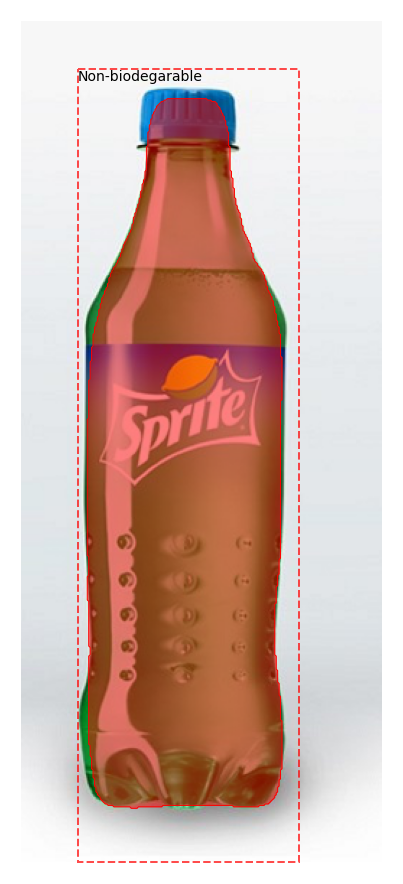

In [16]:
for cnnresults in pred_list:
    if cnnresults[0][0] > cnnresults[0][1]:
        mrcnn.visualize.display_instances(image, r['rois'], r['masks'], np.array([79]), 
                                CLASS_NAMES)
    else:
        mrcnn.visualize.display_instances(image, r['rois'], r['masks'],np.array([80]), 
                                CLASS_NAMES)

### Combine the Mask RCNN and CNN model

In [96]:
def detect_trash_class(image, cnn_model,img_size = (160, 160)):
    image = imread(image)
    
    # Run detection using MaskRCNN
    results = model.detect([image], verbose=0)
    
    r = results[0]
    trash_list = []
    required_size = img_size
    
    for score in range(len(r['scores'])):
        res =r['rois'][score]
    
        #Bounding box
        y1, x1, y2, x2 = res

        # Get trash
        trash = image[y1:y2, x1:x2]

        # Resize trash image
        trash = Image.fromarray(trash)
        trash = trash.resize(required_size)

        # Convert image to numpy array
        trash = np.asarray(trash)

        # Store to list
        trash_list.append(trash)
      
    # Predicting each segmented image to CNN model
    pred_list = []
    for img in trash_list:
        img = np.expand_dims(img, axis=0)/255.
        preds = cnn_model.predict(img)
        pred_list.append(preds)

    
    rclassids = []
    for cnnresults in pred_list:
        if cnnresults[0][0] > cnnresults[0][1]:
            rclassids.append(79)

        else:
            rclassids.append(80)

    rclassids = np.array(rclassids).astype(np.int32)

    return mrcnn.visualize.display_instances(image, r['rois'], r['masks'], rclassids, 
                                CLASS_NAMES)

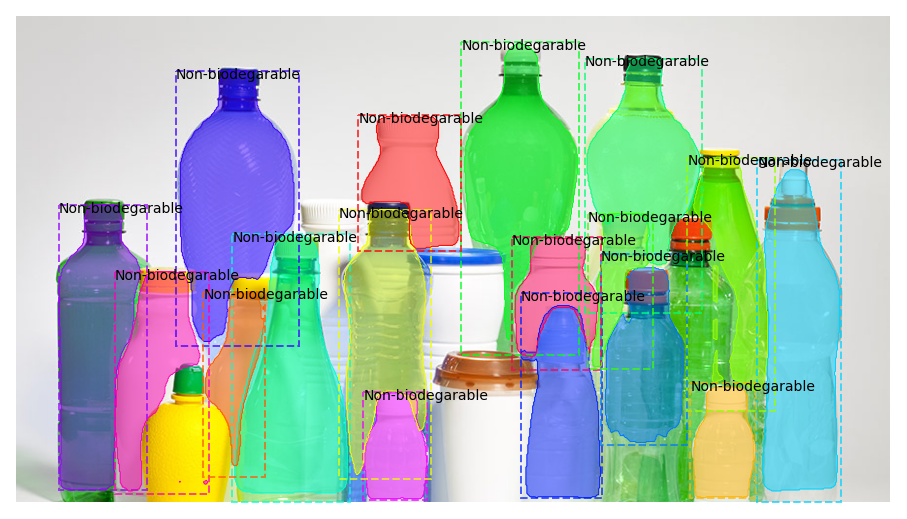

In [99]:
detect_trash_class(
    image="/home/msds2021/qmendez/ThirdTerm/ML2/ML_Project/maskrcnn/ml_project/many_plastics.jpg", cnn_model=cnn_model)

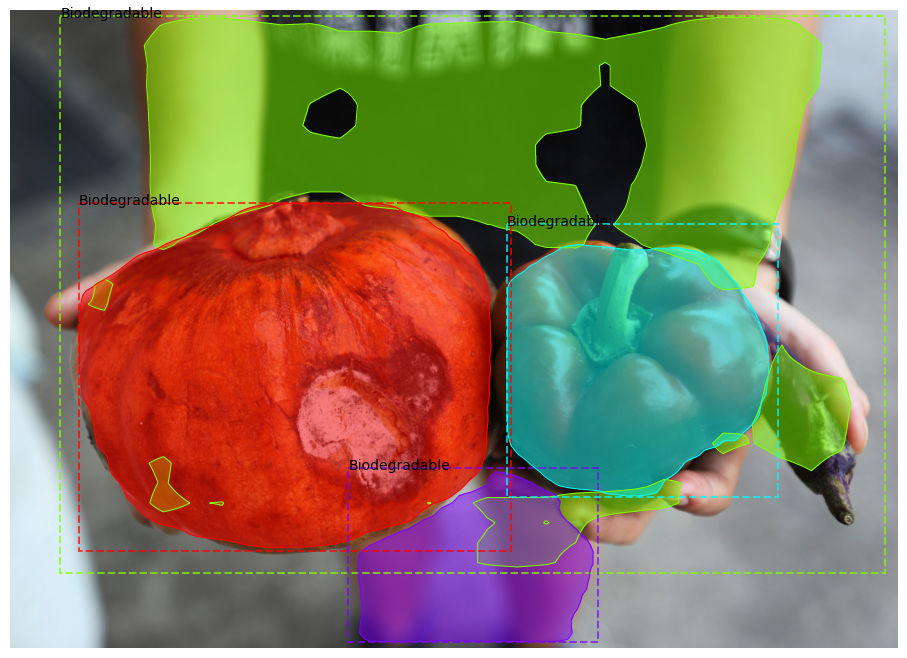

In [128]:
detect_trash_class(
    image="/home/msds2021/qmendez/ThirdTerm/ML2/ML_Project/maskrcnn/ml_project/bio8.jpg", cnn_model=cnn_model)

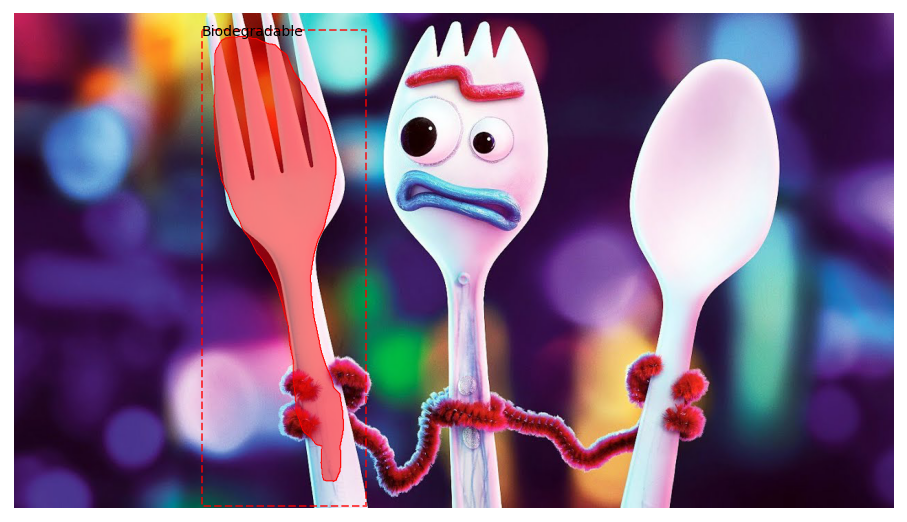

In [153]:
detect_trash_class(
    image="forky.jpg", cnn_model=cnn_model)

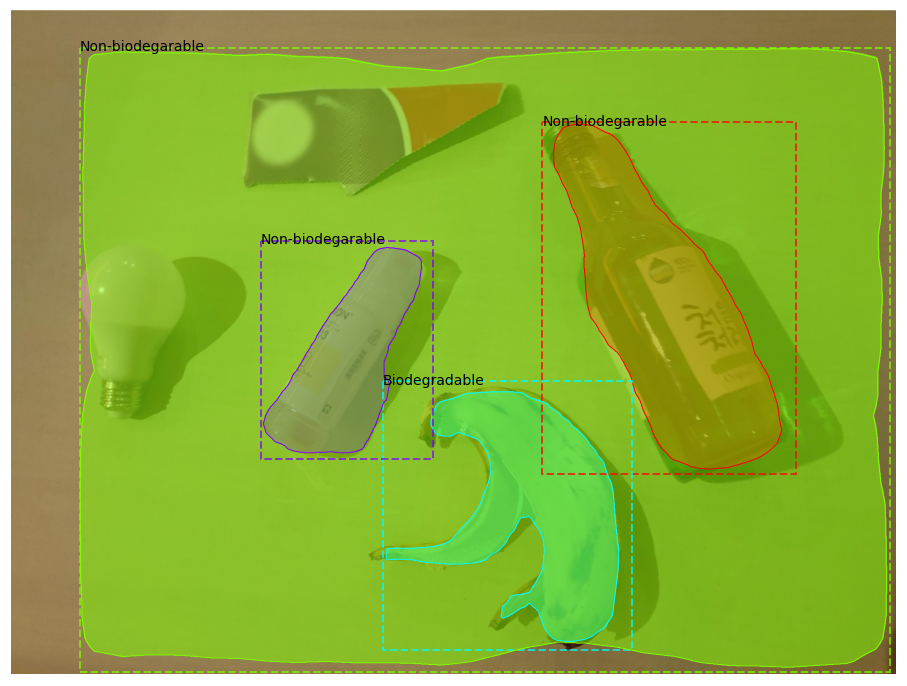

In [155]:
detect_trash_class(
    image="len_trash4.png", cnn_model=cnn_model)

In [ ]:
# Retain objects from region props
from skimage.measure import label, regionprops

# Regionprops


## Apply to Video

In [163]:
import numpy as np
import argparse
import imutils
import time
import cv2
import os

### Initiating the labels and colors of bounding boxes

In [ ]:
LABELS = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 
               'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 
               'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 
               'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 
               'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
               'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 
               'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 
               'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 
               'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 
               'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
               'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 
               'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 
               'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 
               'scissors', 'teddy bear', 'Biodegradable', 'Non-biodegarable']

np.random.seed(42)

COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
                           dtype="uint8")

In [166]:
# derive the paths to the Mask R-CNN weights and model configuration
weightsPath = "mask_rcnn_coco.h5"
configPath = SimpleConfig()

# load our Mask R-CNN trained on the COCO dataset (90 classes)
# from disk
print("[INFO] loading Mask R-CNN from disk...")
net = cv2.dnn.readNetFromTensorflow(weightsPath, configPath)

[INFO] loading Mask R-CNN from disk...


SystemError: <built-in function readNetFromTensorflow> returned NULL without setting an error

### Read video file

In [177]:
# initialize the video stream and pointer to output video file

filepath = 'vid1.mp4'

vs = cv2.VideoCapture(filepath)
writer = None

# try to determine the total number of frames in the video file
try:
    prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
        else cv2.CAP_PROP_FRAME_COUNT
    total = int(vs.get(prop))
    print("[INFO] {} total frames in video".format(total))

    # an error occurred while trying to determine the total
# number of frames in the video file

except:
    print("[INFO] could not determine # of frames in video")
    total = -1

[INFO] 472 total frames in video


In [187]:
# loop over frames from the video file stream

while True:
    # read the next frame from the file
    (grabbed, frame) = vs.read()
    # if the frame was not grabbed, then we have reached the end
    # of the stream
    
    if not grabbed:
        break
        
    # construct a blob from the input frame and then perform a
    # forward pass of the Mask R-CNN, giving us (1) the bounding box
    # coordinates of the objects in the image along with (2) the
    # pixel-wise segmentation for each specific object
    
    blob = cv2.dnn.blobFromImage(frame, swapRB=True, crop=False)
    img = imread(frame)
#     roi = cv2.resize(fc, (48, 48))
#     image = blob
    
#     start = time.time()
    
#     results = model.detect([image], verbose=0)
#     r = results[0]
#     boxes, masks = r['rois'], r['masks'] 
    
# #     (boxes, masks) = net.forward(["detection_out_final",
# #             "detection_masks"])
#     end = time.time()

In [190]:
blob

array([[[[46., 46., 46., ..., 57., 54., 51.],
         [48., 48., 48., ..., 57., 54., 51.],
         [51., 51., 51., ..., 56., 54., 53.],
         ...,
         [36., 36., 36., ..., 36., 37., 39.],
         [34., 34., 34., ..., 36., 37., 39.],
         [34., 34., 34., ..., 37., 39., 40.]],

        [[30., 30., 30., ..., 62., 59., 56.],
         [32., 32., 32., ..., 62., 59., 56.],
         [35., 35., 35., ..., 61., 59., 58.],
         ...,
         [35., 35., 35., ..., 39., 40., 42.],
         [33., 33., 33., ..., 39., 40., 42.],
         [33., 33., 33., ..., 40., 42., 43.]],

        [[15., 15., 15., ..., 61., 58., 55.],
         [17., 17., 17., ..., 61., 58., 55.],
         [20., 20., 20., ..., 60., 58., 57.],
         ...,
         [38., 38., 38., ..., 46., 47., 49.],
         [36., 36., 36., ..., 46., 47., 49.],
         [36., 36., 36., ..., 47., 49., 50.]]]], dtype=float32)

### Video Object Detection

In [353]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 
               'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 
               'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 
               'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 
               'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
               'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 
               'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 
               'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 
               'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 
               'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
               'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 
               'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 
               'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 
               'scissors', 'teddy bear', 'Biodegradable', 'Non-biodegarable']

In [365]:
class SimpleConfig(mrcnn.config.Config):
    # Give the configuration a recognizable name
    NAME = "coco_inference"
    
    # set the number of GPUs to use along with the number of images per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes = number of classes + 1 (+1 for the background). The background class is named BG
    NUM_CLASSES = len(CLASS_NAMES)

# Initialize the Mask R-CNN model for inference and then load the weights.
# This step builds the Keras model architecture.
model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

# # # Load the weights into the model.
model.load_weights(filepath="mask_rcnn_coco.h5", 
                   by_name=True)

In [366]:
filepath = 'vid1.mp4'

video = cv2.VideoCapture(filepath)
writer = None
(W, H) = (None, None)

# Find OpenCV version
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

if int(major_ver) < 3 :
    fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
else :
    fps = video.get(cv2.CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))

frames = []
frame_count = 0

Frames per second using video.get(cv2.CAP_PROP_FPS) : 29.928307331589863


In [368]:
while True:
    ret, frame = video.read() 
    frame = np.expand_dims(frame, axis=0)/255.
    print(frame)
#     frame = cv2.dnn.blobFromImage(frame, 1 / 255.0, swapRB=True, crop=False)
    
#     if not ret:
#         break
    
# #     if W is None or H is None:
# #         (H, W) = frame.shape[:2]
        
    frame_count += 1
    frames.append(frame)
    
    print("frame_count :{}".format(frame_count)) 
    
    if len(frames) == 1:
        results = model.detect(frames, verbose=0)
        print("Predicted")
        print(results)
        
    for i, item in enumerate(zip(frames, results)):
        frame = item[0]
        r = item[1]
        
        trash_list = []
        required_size = (160, 160)
    
        for score in range(len(r['scores'])):
            res =r['rois'][score]
    
            #Bounding box
            y1, x1, y2, x2 = res

            # Get trash
            trash = frame[y1:y2, x1:x2]

            # Resize trash image
            trash = Image.fromarray(trash)
            trash = trash.resize(required_size)

            # Convert image to numpy array
            trash = np.asarray(trash)

            # Store to list
            trash_list.append(trash)
      
        # Predicting each segmented image to CNN model
        pred_list = []
        for img in trash_list:
            img = np.expand_dims(img, axis=0)/255.
            preds = cnn_model.predict(img)
            pred_list.append(preds)

        rclassids = []
        
        for cnnresults in pred_list:
            if cnnresults[0][0] > cnnresults[0][1]:
                rclassids.append(79)

            else:
                rclassids.append(80)

        rclassids = np.array(rclassids).astype(np.int32)
        
        frame_mask = mrcnn.visualize.display_instances(
            frame, r['rois'], r['masks'], rclassids, class_names)
        
#         cv2.imwrite(name, )
#         # check if the video writer is None
#         if writer is None:
#             # initialize our video writer
#             fourcc = cv2.VideoWriter_fourcc(*"MJPG")
#             writer = cv2.VideoWriter(args["output"], fourcc, 30,
#                 (frame.shape[1], frame.shape[0]), True)

#             # some information on processing single frame
#             if total > 0:
#                 elap = (end - start)
#                 print("[INFO] single frame took {:.4f} seconds".format(elap))
#                 print("[INFO] estimated total time to finish: {:.4f}".format(
#                     elap * total))

#         # write the output frame to disk
#     writer.write(frame)
#         name = '{}.jpg'.format(frame_count + i - batch_size)
#         name = os.path.join('/home/msds2021/qmendez/ThirdTerm/ML2/ML_Project/maskrcnn/video/trial_vid1', name)
#         cv2.imwrite(name, frame)
#         print('writing to file:{}'.format(name))
        
         # Clear the frames array to start the next batch
#         frames = []
        
video.release()

[[[[0.07843137 0.10196078 0.11764706]
   [0.09411765 0.11764706 0.13333333]
   [0.11372549 0.14117647 0.14509804]
   ...
   [0.17254902 0.18823529 0.14117647]
   [0.17254902 0.18823529 0.14117647]
   [0.17254902 0.18823529 0.14117647]]

  [[0.0745098  0.09803922 0.11372549]
   [0.09019608 0.11372549 0.12941176]
   [0.10588235 0.13333333 0.1372549 ]
   ...
   [0.17254902 0.18823529 0.14117647]
   [0.17254902 0.18823529 0.14117647]
   [0.17254902 0.18823529 0.14117647]]

  [[0.07843137 0.10196078 0.11764706]
   [0.09411765 0.11764706 0.13333333]
   [0.10196078 0.12941176 0.13333333]
   ...
   [0.17254902 0.18823529 0.14117647]
   [0.17254902 0.18823529 0.14117647]
   [0.17254902 0.18823529 0.14117647]]

  ...

  [[0.36078431 0.36862745 0.55686275]
   [0.36078431 0.36862745 0.55686275]
   [0.36078431 0.36862745 0.55686275]
   ...
   [0.15294118 0.15686275 0.11372549]
   [0.15294118 0.15686275 0.11372549]
   [0.14901961 0.15294118 0.10980392]]

  [[0.36078431 0.36862745 0.55686275]
   [0.3

ValueError: len(output_shape) cannot be smaller than the image dimensions